# 1. Setup

In [ ]:
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))

In [ ]:
# Horizontal Scrolling
import io
import base64
from IPython.display import HTML, display

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame, Series, Timedelta
from scipy.ndimage import binary_dilation
from sklearn.metrics import mean_absolute_error as MAE

In [ ]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from xgboost import XGBRegressor

In [ ]:
from utils.loading import load_all_raw_data
from utils.preprocessing import process_all_dfs
from utils.merging import merge_all_dfs
from utils.feature_engineering import *

In [ ]:
pd.set_option(
    "display.float_format",
    lambda x: f"{x:.2e}" if abs(x) < 0.01 and x != 0 else f"{x:.2f}",
)
pd.set_option('display.max_columns', 100)
pd.set_option("display.max_rows", 100)

In [ ]:
RAW_DATA_PATH = "../data/raw_data/"
ADDITIONAL_DATA_PATH = "../data/additional_data/"

SEGMENT_C = ["county", "product_type", "is_business"]
CATEGORICAL_C = ["county", "product_type", "is_business", "is_consumption"]
TARGET_C = [
    "county",
    "product_type",
    "is_business",
    "is_consumption",
    "datetime",
]
RAND = 10

# 2. Processing

In [ ]:
processed_dfs = process_all_dfs(
    load_all_raw_data(RAW_DATA_PATH, ADDITIONAL_DATA_PATH)
)

# processed_dfs.keys()
df = merge_all_dfs(processed_dfs, how="left")
df = add_dst_flag(df)
df = add_cyclic_datetime_features(df, drop_raw=True)

In [ ]:
for lag in [2, 3, 7]:
# for lag in range(2, 15):
    df = df.merge(
        get_lag(processed_dfs["train"][TARGET_C + ["target"]], lag=lag),
        how="left",
        on=TARGET_C,
    )

In [ ]:
for window in [24, 24 * 3, 24 * 7, 24 * 14]:
    # for window in [24 * i for i in range(1, 15)]:
    df = df.merge(
        get_moving_average(
            processed_dfs["train"]
            .set_index("datetime")
            .sort_index()
            .groupby(CATEGORICAL_C, observed=True, as_index=False),
            columns=["target"],
            window=window,
            # ).dropna(),
        ),
        how="left",
        on=TARGET_C,
    )

In [ ]:
df["t_over_cap"] = (df["2d_lag_target"] / df["installed_capacity"]).astype(
    "float32"
)
df["t_over_eic"] = (df["2d_lag_target"] / df["eic_count"]).astype("float32")
df["cap_per_eic"] = (df["installed_capacity"] / df["eic_count"]).astype(
    "float32"
)

In [ ]:
# w, h = 20, 14

# fig, ax = plt.subplots(figsize=(w, h))
# # plt.figure(figsize=(w, h))

# sns.heatmap(
#     df.drop(
#         columns=df.select_dtypes(["category"]).columns.tolist()
#         + [
#             "datetime",
#             "data_block_id",
#             "date",
#         ]
#     ).corr(),
#     annot=True,
#     fmt=".1f",
#     annot_kws={"size": 7},
# )


# buf = io.BytesIO()
# fig.savefig(buf, format="png", bbox_inches="tight")
# buf.seek(0)
# img_base64 = base64.b64encode(buf.getvalue()).decode("utf-8")

# html_code = (
#     '<div style="overflow-x: auto; width: 100%;">'
#     '<img src="data:image/png;base64,{}" style="display: block; max-width: none; width: auto;">'
#     "</div>"
# ).format(img_base64)

# display(HTML(html_code))
# plt.close(fig)
# # plt.show()

In [ ]:
# df_for_missing = df[TARGET_C + ["target"]].dropna().copy()

# # Add hour index starting from the beginning
# df_for_missing["hour_index"] = (
#     (df_for_missing["datetime"] - df_for_missing["datetime"].min())
#     // pd.Timedelta(hours=1)
# ).astype(np.uint16)


# # Add a group index corresponding to the unique combination of all
# # categorical features (i.e. this feature is not equal to
# # prediction_unit_id): county, is_business, product_type,
# # is_consumption.
# # The maximum number of combinations is 16 * 4 * 2 * 2 = 256, but the
# # actual number of observed values is less than 256
# df_for_missing["group_index"] = (
#     df_for_missing.groupby(
#         CATEGORICAL_C,
#         observed=True,
#     )
#     .ngroup()
#     .astype(np.uint8)
# )

# # Create a 2D array with a shape equal to the number of groups and the
# # total number of hours between the minimum and maximum timestamps
# n_groups = df_for_missing["group_index"].nunique()
# n_hours = df_for_missing["hour_index"].max() + 1
# missmap = np.full((n_groups, n_hours), np.nan)

# # Fill the array with the corresponding flag values
# missmap[df_for_missing["group_index"], df_for_missing["hour_index"]] = (
#     df_for_missing["target"] != 0
# )

# # Dilate missing values because of high density of plot and isolated
# # missing values are not visible.
# n = 6  # How many hours before and after count as missing
# structure = np.ones((1, 2 * n + 1), dtype=bool)
# missing_dilated = binary_dilation(np.isnan(missmap), structure=structure)
# missmap[missing_dilated] = np.nan

# alpha = 0.8

# min_date = df_for_missing["datetime"].min()
# max_date = df_for_missing["datetime"].max()
# n_months = len(pd.date_range(start=min_date, end=max_date, freq="ME"))


# fig, ax = plt.subplots(figsize=(14, 7))
# sns.heatmap(
#     missmap,
#     cmap=sns.color_palette(["tab:blue", "tab:orange"]),
#     cbar=False,
#     alpha=alpha,
#     ax=ax,
# )

# xtick_indices = np.linspace(0, n_hours, num=n_months, dtype=int)
# xtick_labels = pd.date_range(min_date, max_date, freq="ME")


# ax.set_xticks(xtick_indices)
# ax.set_xticklabels(xtick_labels.strftime("%Y-%m"), rotation=45, ha="right")

# dx, dy = 0, -2.5
# for label in ax.get_yticklabels():
#     offset = mt.ScaledTranslation(dx / 72, dy / 72, fig.dpi_scale_trans)
#     label.set_transform(label.get_transform() + offset)

# legend_patches = [
#     mpatches.Patch(
#         facecolor="white",
#         label="Missing value",
#         edgecolor="black",
#         linewidth=0.5,
#     ),
#     mpatches.Patch(
#         facecolor="tab:blue",
#         alpha=alpha,
#         label="Zero value",
#         edgecolor="black",
#         linewidth=0.5,
#     ),
#     mpatches.Patch(
#         facecolor="tab:orange",
#         alpha=alpha,
#         label="Not zero value",
#         edgecolor="black",
#         linewidth=0.5,
#     ),
# ]

# plt.legend(
#     handles=legend_patches,
#     title="Data Presence",
#     title_fontsize=12,
#     bbox_to_anchor=(1, 1),
#     loc="upper left",
#     fontsize=11,
#     frameon=False,
# )

# plt.title(
#     "Heatmap of time series gaps for all combinations "
#     "of categorical features",
#     fontsize=13,
# )
# plt.xlabel("Month", fontsize=10)
# plt.ylabel("Group index", fontsize=10)
# plt.grid(False)
# plt.show()

# 3. Baselines comparison

In [ ]:
# def split_by_equal_days(
#     dt: Series,
#     train_days: int = 1,
#     fh_days: int = 1,  # Only daily predictions as per problem statement
#     n_splits: int = 1,
#     expanding: bool = False,
# ) -> list[dict[str, tuple[pd.Timestamp, pd.Timestamp]]]:
#     """
#     Split datetime Series into multiple train and validation splits. A
#     day is counted from 00:00 to 23:00 inclusive.

#     Parameters
#     ----------
#     dt : pd.Series
#         Series with hourly datetime values.
#     train_days : int, default=1
#         Number of days in each training window.
#     fh_days : int, default=1
#         Forecast horizon in days (length of validation window). Each
#         forecast day runs from 00:00 to 23:00. Default is 1, since all
#         predictions are made day-by-day.
#     n_splits : int, default=1
#         Number of (train, validation) subsamples to generate.
#     expanding : bool, default=False
#         If True, use an expanding training window, otherwise use a
#         rolling window of fixed length.

#     Returns
#     -------
#     List[dict[str, tuple[pd.Timestamp, pd.Timestamp]]]
#         A list of dictionaries. Each dictionary has keys "train" and
#         "val", mapping to start and end timestamps for that split.

#     Raises
#     ------
#     ValueError
#         If `n_splits` is greater than the number of days available in
#         the intermediate period between the initial training window and
#         the final forecast horizon.
#     """
#     dt = dt.dt.floor("D")  # Processing on a day scope

#     train_days = Timedelta(days=train_days)
#     train_days_delta = train_days - Timedelta(days=1)  # Indexing from 0

#     fh_days = Timedelta(days=fh_days)
#     fh_days_delta = fh_days - Timedelta(days=1)  # Indexing from 0

#     first_day = dt.min()
#     last_day = dt.max()

#     # test_start = last_day - fh_days_delta
#     # test_end = last_day + pd.Timedelta(hours=23)

#     intermediate_period_start = first_day + train_days
#     intermediate_period_end = last_day - fh_days
#     intermediate_period_days = (
#         intermediate_period_end - intermediate_period_start
#     ).days

#     if intermediate_period_days >= 0:
#         max_allowed = intermediate_period_days + 1
#     else:
#         max_allowed = 1
#     if n_splits > max_allowed:
#         raise ValueError(
#             "n_splits exceeds the length of the validation period.")

#     splits = []
    
#     base_step = Timedelta(days=intermediate_period_days // n_splits)
#     step_rem = Timedelta(days=intermediate_period_days % n_splits)

#     for step in range(n_splits):
#         offset = base_step * step + min(Timedelta(days=step), step_rem)
#         if expanding:
#             train_start = first_day
#             train_end = (
#                 train_start
#                 + train_days_delta
#                 + offset
#                 + Timedelta(hours=23)
#             )
#         else:
#             train_start = first_day + offset
#             train_end = train_start + train_days_delta + Timedelta(hours=23)

#         val_start = train_end + Timedelta(hours=1)
#         val_end = val_start + fh_days_delta + Timedelta(hours=23)
#         splits.append(
#             {
#                 "train": (train_start, train_end),
#                 "val": (val_start, val_end),
#                 # "test": (test_start, test_end),
#             }
#         )

#     return splits

In [ ]:
print(
    f"First timestamp: {df["datetime"].min()}",
    f"Last timestamp: {df["datetime"].max()}",
    sep="\n"
)

First timestamp: 2021-09-01 00:00:00
Last timestamp: 2023-05-31 23:00:00


Since the minimum usable lag for prediction is 48 hours, this horizon is particularly well suited as a naive baseline.

In [ ]:
FEATURES_TO_DROP = ["datetime", "data_block_id", "date"]

In [ ]:
# df["datetime"].is_monotonic_increasing
# df = df.sort_values('datetime', ignore_index=True)

In [ ]:
VAL_SPLITS = 5

In [ ]:
# train - val - test
# .64 - .16 - .20

In [ ]:
val_dt_start = (
    df["datetime"].min() + (df["datetime"].max() - df["datetime"].min()) * 0.64
).normalize()
test_dt_start = (
    df["datetime"].min() + (df["datetime"].max() - df["datetime"].min()) * 0.8
).normalize()
print(
    f"Validation period starts: {val_dt_start}",
    f"Test period starts: {test_dt_start}",
    sep="\n",
)

Validation period starts: 2022-10-14 00:00:00
Test period starts: 2023-01-24 00:00:00


In [ ]:
train_days_range = (
    val_dt_start - Timedelta(hours=1) - df["datetime"].min()
).days
train_days_range

407

In [ ]:
splits_fixed = split_by_equal_days(
    dt=df.loc[df["datetime"] < test_dt_start, "datetime"],
    train_days=train_days_range,
    fh=7, # weekly retraining
    n_splits=VAL_SPLITS,
    expanding=False,
)

new_splits = []

for i, d in enumerate(splits_fixed):
    count = len(
        df.loc[
            (df["datetime"] >= d["val"][0]) & (df["datetime"] <= d["val"][1])
        ]
    )
    if count < 24:
        print(f"Split {i} only has {count} rows, removed")
    else:
        new_splits.append(d)

splits_fixed = new_splits
for i, d in enumerate(splits_fixed):
    print(i, "train", d["train"])
    print(i, "valid", d["val"])

0 train (Timestamp('2021-09-01 00:00:00'), Timestamp('2022-10-12 23:00:00'))
0 valid (Timestamp('2022-10-13 00:00:00'), Timestamp('2022-10-19 23:00:00'))
1 train (Timestamp('2021-09-21 00:00:00'), Timestamp('2022-11-01 23:00:00'))
1 valid (Timestamp('2022-11-02 00:00:00'), Timestamp('2022-11-08 23:00:00'))
2 train (Timestamp('2021-10-10 00:00:00'), Timestamp('2022-11-20 23:00:00'))
2 valid (Timestamp('2022-11-21 00:00:00'), Timestamp('2022-11-27 23:00:00'))
3 train (Timestamp('2021-10-29 00:00:00'), Timestamp('2022-12-09 23:00:00'))
3 valid (Timestamp('2022-12-10 00:00:00'), Timestamp('2022-12-16 23:00:00'))
4 train (Timestamp('2021-11-17 00:00:00'), Timestamp('2022-12-28 23:00:00'))
4 valid (Timestamp('2022-12-29 00:00:00'), Timestamp('2023-01-04 23:00:00'))


In [ ]:
cat_cols = df.select_dtypes(include="category").columns.tolist()

(
    naive_mae,
    xgb_mae_history,
    lgbm_mae_history,
    cb_mae_history,
) = (
    [],
    [],
    [],
    [],
)

xgb_p = {
    "n_estimators": 100,
    "learning_rate": 0.1,
    "max_depth": 7,
    "random_state": RAND,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": "reg:absoluteerror",
    "enable_categorical": True,
    "early_stopping_rounds": 20,
    "eval_metric": "mae",
    "n_jobs": -1,
}
lgbm_p = {
    "n_estimators": 100,
    "learning_rate": 0.1,
    "max_depth": 7,
    "random_state": RAND,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": "regression_l1",
    "metric": "mae",
    "n_jobs": -1,
    "force_col_wise": True,
    "verbosity": -1,
}
cb_p = {
    "n_estimators": 100,
    "learning_rate": 0.1,
    "max_depth": 7,
    "random_state": RAND,
    "subsample": 0.8,
    "colsample_bylevel": 0.8,
    "loss_function": "MAE",
    "cat_features": cat_cols,
    "eval_metric": "MAE",
    "thread_count": -1,
    "verbose": False,
}

xgbr = XGBRegressor(**xgb_p)
lgbmr = LGBMRegressor(**lgbm_p)
cbr = CatBoostRegressor(**cb_p)

for split in splits_fixed:
    df_train = df[
        (df["datetime"] >= split["train"][0])
        & (df["datetime"] <= split["train"][1])
    ].drop(FEATURES_TO_DROP, axis=1)
    df_val = df[
        (df["datetime"] >= split["val"][0])
        & (df["datetime"] <= split["val"][1])
    ].drop(FEATURES_TO_DROP, axis=1)

    X_train, y_train = (
        df_train.drop(["target"], axis=1),
        df_train["target"],
    )
    X_val, y_val = df_val.drop(["target"], axis=1), df_val["target"]
    # X_test, y_test = df_test.drop(["target"], axis=1), df_test["target"]

    eval_set = [
        (X_train, y_train),
        (X_val, y_val),
        # (X_test, y_test)
    ]
    # print(f"{i+1} split")

    # Naive baseline
    naive_mae.append(
        {
            "validation_0": MAE(
                eval_set[0][1].loc[X_train["2d_lag_target"].notna()],
                eval_set[0][0]["2d_lag_target"].loc[
                    X_train["2d_lag_target"].notna()
                ],
            ),
            "validation_1": MAE(
                eval_set[1][1].loc[X_val["2d_lag_target"].notna()],
                eval_set[1][0]["2d_lag_target"].loc[
                    X_val["2d_lag_target"].notna()
                ],
            ),
        }
    )

    for model in [
        xgbr,
        lgbmr,
        cbr,
    ]:
        # print("-" * 30)
        # print("train")
        # print("start:", split["train"][0])
        # print("end:", split["train"][1])
        # print("shape:", X_train.shape, y_train.shape)

        # print("-" * 30)
        # print("val")
        # print("start:", split["val"][0])
        # print("end:", split["val"][1])
        # print("shape:", X_val.shape, y_val.shape)

        # print("-" * 30)
        # print("test")
        # print("start:", test_start)
        # print("end:", test_end)
        # print("shape:", X_test.shape, y_test.shape)

        if isinstance(model, XGBRegressor):
            # print("XGBRegressor")
            model.fit(
                X_train,
                y_train,
                eval_set=eval_set,
                verbose=0,
                # verbose=25,
            )
            xgb_mae_history.append(model.evals_result())

        elif isinstance(model, LGBMRegressor):
            # print("LGBMRegressor")
            model.fit(
                X_train,
                y_train,
                categorical_feature=cat_cols,
                eval_set=eval_set,
                callbacks=[
                    early_stopping(
                        stopping_rounds=20,
                        verbose=0,
                    ),
                    # log_evaluation(period=25),
                ],
            )
            lgbm_mae_history.append(model.evals_result_)

        elif isinstance(model, CatBoostRegressor):
            # print("CatBoostRegressor")
            model.fit(
                X_train, y_train, eval_set=eval_set, early_stopping_rounds=20
            )
            cb_mae_history.append(model.evals_result_)

In [ ]:
# xgb_mae_history[0]
# lgbm_mae_history[0]
# cb_mae_history[0]

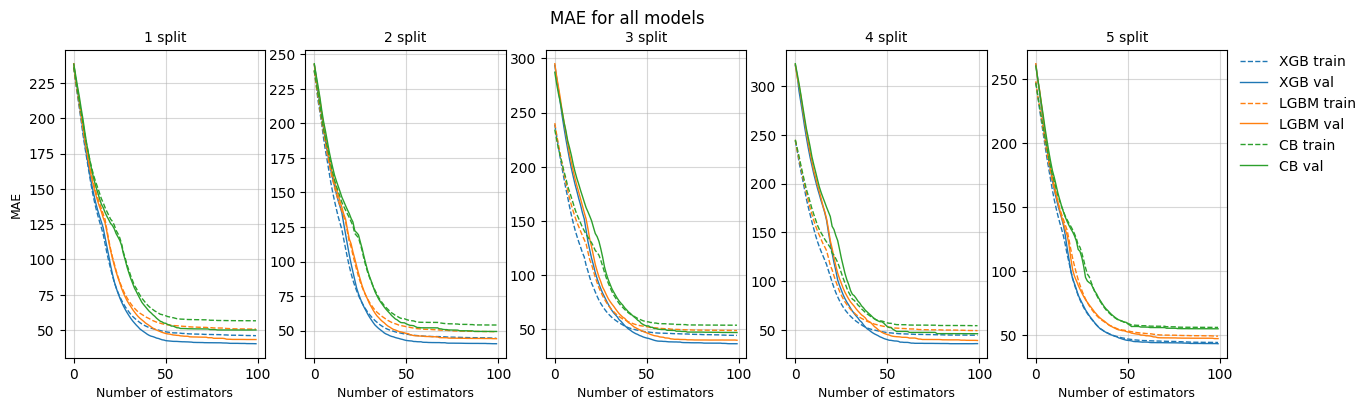

In [ ]:
total_splits = len(splits_fixed)
rows, cols = 1, VAL_SPLITS
fig, axs = plt.subplots(rows, cols, figsize=(15, 4))

axs = axs.flatten()

for split_i in range(total_splits):
    ax = axs[split_i]
    ax.plot(
        xgb_mae_history[split_i]["validation_0"]["mae"],
        "C0--",
        label=f"XGB train",
        lw=1,
    )
    ax.plot(
        xgb_mae_history[split_i]["validation_1"]["mae"],
        "C0",
        label=f"XGB val",
        lw=1,
    )
    ax.plot(
        lgbm_mae_history[split_i]["training"]["l1"],
        "C1--",
        label=f"LGBM train",
        lw=1,
    )
    ax.plot(
        lgbm_mae_history[split_i]["valid_1"]["l1"],
        "C1",
        label=f"LGBM val",
        lw=1,
    )
    ax.plot(
        cb_mae_history[split_i]["validation_0"]["MAE"],
        "C2--",
        label=f"CB train",
        lw=1,
    )
    ax.plot(
        cb_mae_history[split_i]["validation_1"]["MAE"],
        "C2",
        label=f"CB val",
        lw=1,
    )

    if split_i >= total_splits - cols:
        ax.set_xlabel("Number of estimators", size=9)
    if split_i in [i * cols for i in range(rows)]:
        ax.set_ylabel("MAE", size=9)
    ax.set_title(f"{split_i + 1} split", size=10)
    ax.grid(which="both", alpha=0.5)

plt.legend(
    loc="upper left",
    bbox_to_anchor=(1, 1.025),
    frameon=False,
)
fig.suptitle(
    "MAE for all models",
    # y=1.0125,
    fontsize=12,
)
# plt.tight_layout()
plt.show()

In [ ]:
naive_results_mae = {
    sample: np.mean([item[sample] for item in naive_mae])
    for sample in ["validation_0", "validation_1"]
}
xgb_results_mae = {
    sample: np.mean([split[sample]["mae"][-1] for split in xgb_mae_history])
    for sample in ["validation_0", "validation_1"]
}
lgbm_results_mae = {
    sample: np.mean([split[sample]["l1"][-1] for split in lgbm_mae_history])
    for sample in ["training", "valid_1"]
}
cb_results_mae = {
    sample: np.mean([split[sample]["MAE"][-1] for split in cb_mae_history])
    for sample in ["validation_0", "validation_1"]
}

In [ ]:
results_df = DataFrame(
    {
        "train mean MAE": [
            naive_results_mae["validation_0"],
            xgb_results_mae["validation_0"],
            lgbm_results_mae["training"],
            cb_results_mae["validation_0"],
        ],
        "validation mean MAE": [
            naive_results_mae["validation_1"],
            xgb_results_mae["validation_1"],
            lgbm_results_mae["valid_1"],
            cb_results_mae["validation_1"],
        ],
    },
    index=["naive", "xgb", "lgbm", "cb"],
)
results_df

,train mean MAE,validation mean MAE
naive,79.14,67.10
xgb,44.79,39.43
lgbm,49.51,42.83
cb,55.03,49.59


The XGBoost baseline shows the best results (MAE: 39.43), while the LightGBM baseline performs slightly worse (MAE: 42.83). The gap with the CatBoost baseline is more significant (MAE: 49.59), and XGBoost clearly outperforms the naive baseline (MAE: 67.10).